# L3: Metadata Extraction and Chunking

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>


In [74]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

In [75]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [76]:
# Procesar el archivo localmente
# brew install pandoc

from unstructured.partition.epub import partition_epub
from unstructured.staging.base import elements_to_json
from unstructured.chunking.title import chunk_by_title
from IPython.display import JSON
import json
import chromadb

## Example Document: Winter Sports in Switzerland EPUB

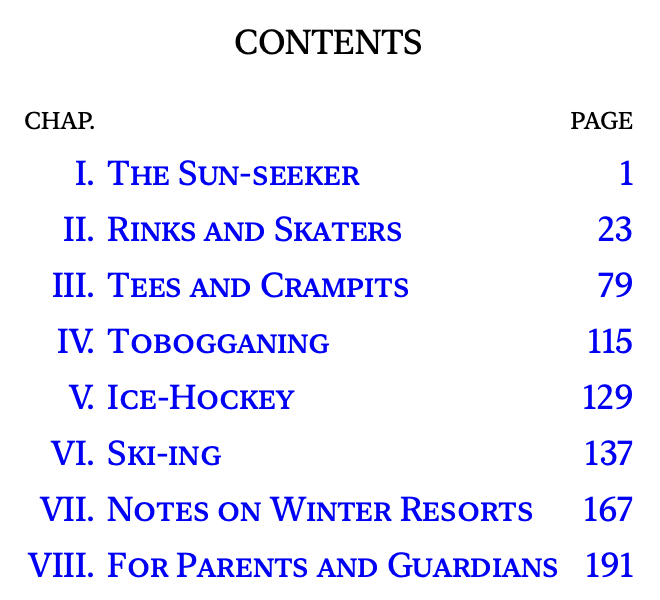

In [77]:
from IPython.display import Image
Image(filename="images/winter-sports-toc.png", height=400, width=400) 

## View the content of the file
- <a href="example_files/winter-sports.pdf">Winter Sports (View PDF) -- Click Here</a>

## Run the document through the Unstructured API

In [78]:
# Procesamiento local del .epub
filename = "example_files/winter-sports.epub"
elements = partition_epub(filename=filename)
element_dicts = json.loads(elements_to_json(elements))
# Vista previa
JSON(element_dicts[:8])


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


<IPython.core.display.JSON object>

In [79]:
[x for x in element_dicts if x['type'] == 'Title' and 'sun-seeker' in x['text'].lower()]

[{'element_id': 'fe80d44bfaa35e89df23a34a07a02d88',
  'metadata': {'category_depth': 1,
   'file_directory': 'example_files',
   'filename': 'winter-sports.epub',
   'filetype': 'application/epub',
   'languages': ['eng'],
   'last_modified': '2025-07-25T11:58:11',
   'parent_id': '58c795af613e066f77a628190ccc8ecd'},
  'text': 'CHAPTER I THE SUN-SEEKER',
  'type': 'Title'}]

In [80]:
# Detectar capítulos (títulos)
chapters = [
    "THE SUN-SEEKER",
    "RINKS AND SKATERS",
    "TEES AND CRAMPITS",
    "TOBOGGANING",
    "ICE-HOCKEY",
    "SKI-ING",
    "NOTES ON WINTER RESORTS",
    "FOR PARENTS AND GUARDIANS",
]

# Mapear títulos a IDs
chapter_ids = {}
for el in elements:
    for chapter in chapters:
        if chapter in el.text and el.category == "Title":
            chapter_ids[el.id] = chapter # el.text
            break

# Invertir el mapeo
chapter_to_id = {v: k for k, v in chapter_ids.items()}


In [81]:
chapter_ids

{'fe80d44bfaa35e89df23a34a07a02d88': 'THE SUN-SEEKER',
 'fc206ef468e41fa742292971fadd132a': 'RINKS AND SKATERS',
 '7a308b2102b609e7131818e09ca98c2b': 'TEES AND CRAMPITS',
 '50515aec778056af8696e8467dea9a94': 'TOBOGGANING',
 '55139ae0f4d31d0703d885e2c543459d': 'ICE-HOCKEY',
 '7d3b48922529f7bfb27a3f7bdf5a52a5': 'SKI-ING',
 '84f344a8ff4ae8f0cd8ddcd61d61537a': 'NOTES ON WINTER RESORTS',
 '83d1664e13edc7a3554603a58a64d0a2': 'FOR PARENTS AND GUARDIANS'}

In [82]:
# Buscar elementos por capítulo (ej: ICE-HOCKEY)
# Buscar el primer elemento del capítulo ICE-HOCKEY
ice_hockey_elements = [
    el for el in elements if el.metadata.parent_id == chapter_to_id["ICE-HOCKEY"]
]
print(ice_hockey_elements[0].text)


Many of the Swiss winter-resorts can put into the field a very strong ice-hockey team, and fine teams from other countries often make winter tours there; but the ice-hockey which the ordinary winter visitor will be apt to join in will probably be of the most elementary and unscientific kind indulged in, when the skating day is drawing to a close, by picked-up sides. As will be readily understood, the ice over which a hockey match has been played is perfectly useless for skaters any more that day until it has been swept, scraped, and sprinkled or flooded; and in consequence, at all Swiss resorts, with the exception of St. Moritz, where there is a rink that has been made for the hockey-player, or when an important match is being played, this sport is supplementary to such others as I have spoken of. Nobody, that is, plays hockey and nothing else, since he cannot play hockey at all till the greedy skaters have finished with the ice.


In [83]:
# Cargar documenrs into a vector db: en ChromaDB
client = chromadb.PersistentClient(path="chroma_tmp", settings=chromadb.Settings(allow_reset=True))
client.reset()

True

In [84]:
collection = client.create_collection(
    name="winter_sports",
    metadata={"hnsw:space": "cosine"}
)

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Wait Time)</code>:</b> The following block can take a few seconds to complete.</p>

In [85]:
# Insertar elementos en vector DB
for el in elements:
    parent_id = el.metadata.parent_id
    chapter = chapter_ids.get(parent_id, "")
    collection.add(
        documents=[el.text],
        ids=[el.id],
        metadatas=[{"chapter": chapter}]
    )

## See the elements in Vector DB

In [86]:
# Ver documentos
results = collection.peek()
print(results["documents"])

['', 'Cover', 'The Project Gutenberg eBook of Winter Sports in Switzerland, by E. F. Benson', 'This ebook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this ebook or online at www.gutenberg.org. If you are not located in the United States, you’ll have to check the laws of the country where you are located before using this eBook.', 'Title: Winter Sports in Switzerland', 'Author: E. F. Benson', 'Illustrator: C. Fleming Williams', 'Photographer: Mrs. Aubrey Le Blond', 'Release date: August 23, 2019 [EBook #60153] Most recently updated: January 30, 2020', 'Language: English']


## Perform a hybrid search with metadata

In [87]:
# Hacer búsqueda híbrida (texto + metadatos)
result = collection.query(
    query_texts=["How many players are on a team?"],
    n_results=2,
    where={"chapter": "ICE-HOCKEY"},
)
print(json.dumps(result, indent=2))

{
  "ids": [
    [
      "949a4c11ad023b7efbf337a33da421f9",
      "914fdcb94ae4e9919a7a5ed4f87a7793"
    ]
  ],
  "embeddings": null,
  "documents": [
    [
      "It is a wonderful and delightful sight to watch the speed and accuracy of a first-rate team, each member of which knows the play of the other five players. The finer the team, as is always the case, the greater is their interdependence on each other, and the less there is of individual play. Brilliant running and dribbling, indeed, you will see; but as distinguished from a side composed of individuals, however good, who are yet not a team, these brilliant episodes are always part of a plan, and end not in some wild shot but in a pass or a succession of passes, designed to lead to a good opening for scoring. There is, indeed, no game at which team play outwits individual brilliance so completely.",
      "Rules of Match Play"
    ]
  ],
  "uris": null,
  "included": [
    "metadatas",
    "documents",
    "distances"
  ],
  

## Chunking Content

In [88]:
# Chunkear por títulos (más limpio para el LLM)
chunks = chunk_by_title(
    elements,
    combine_text_under_n_chars=100,
    max_characters=3000,
)

# Mostrar el primer chunk
JSON(json.loads(json.dumps(chunks[0].to_dict(), indent=2)))


<IPython.core.display.JSON object>

In [89]:
len(elements)

718

In [90]:
len(chunks)

165

## Work With Your Own Files

In [91]:
import panel as pn
#import param
from Utils import upld_file
pn.extension()

upld_widget = upld_file()
pn.Row(upld_widget.widget_file_upload)

Row
    [0] FileInput(accept='.pdf,.ppt,.png,....)

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> 🖥 &nbsp; <b>Note:</b> If the file upload interface isn't functioning properly, the issue may be related to your browser version. In such a case, please ensure your browser is updated to the latest version, or try using a different browser.</p>


In [92]:
!ls ./example_files

winter-sports.epub winter-sports.pdf


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Uploading Your Own File - Method 2:</b> To upload your own files, you can also 1) click on the <em>"View"</em> option on the top menu of the notebook and then 2) click on <em>"File Browser"</em>. Then 3) click on <em>"Upload"</em> button to upload your files. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>